2023 Bart Smeets

# Beam profile

Notebook to analyse the beam profile.

The data-files do not contain z-information, hence the z-data is generated based on an certain step size. To prevent misalignment, the data-files must be continous in z with identical step size.

## Imports

- Import the require packages.

In [22]:
# Python standard library
from datetime import datetime
import tkinter as tk
from tkinter import filedialog
import os, sys, glob

# Required
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Included in repository
from module import gaussian, width

## User inputs

- Open window to ask for directory and change working directory

In [23]:
WAVELENGTH = 532    # Unit nm
STEP_SIZE = 1    # Unit mm

# Set initial directory
INITIAL_PATH = os.environ.get('THESIS_DATA')

# Create window for file selection
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
DIRECTORY = filedialog.askdirectory(initialdir=INITIAL_PATH, title='Select directory')
root.destroy()

# Set working directory
os.chdir(DIRECTORY)

## Load Data
DATA is a list containing 2D pandas data sets. <br>
The data sets contain x- and y-measurements of the beam profile:
<ul> 
    <li> First index changes changes the x- and y-coordinates of the measurement </li>
    <li> Second index indicates the measured quantity: </li>
    <ol>
        <li> x-position </li>
        <li> I(x) </li>
        <li> y-position </li>
        <li> I(y) </li>
    </ol>
</ul>

In [24]:
# Initialise data structures
ALL_FILES = glob.glob('Data_*.txt')
N_MEASUREMENTS = len(ALL_FILES)
Z = STEP_SIZE * np.array(range(N_MEASUREMENTS))    # unit mm
DATA = [None] * N_MEASUREMENTS

# Check if ALL_FILES is empty
if len(ALL_FILES) == 0:
    sys.exit('No "Data_*.txt" in directory')

# Store measurements in list
for i in range(N_MEASUREMENTS):
    file_name = ALL_FILES[i]
    measurement = pd.read_csv(file_name,header=None, skiprows=11,delim_whitespace=True,encoding='latin1')
    DATA[i] = measurement

# Define output directory
OUTPUT_DIRECTORY = './Output_Beam_Profile/'
if not os.path.exists(OUTPUT_DIRECTORY):
    os.mkdir(OUTPUT_DIRECTORY)
os.chdir(OUTPUT_DIRECTORY)

### Exclude data

- This section excludes data points

- Fill in the index of the data point that needs to be removed

In [25]:
# USER INPUT
exclude = []    # Enter index of datapoint to be excluded

# Exclude data
removed = 0
for index in exclude:
    DATA.pop(index-removed)
    Z = np.delete(Z,index-removed,0)
    removed += 1
N_MEASUREMENTS -= removed

## Fit data

### Fit width (Gaussian)

- Do a Gaussian fit of the I(x) and I(y) beam profiles, i.e. the intensity cross-section at a given z-coordinate

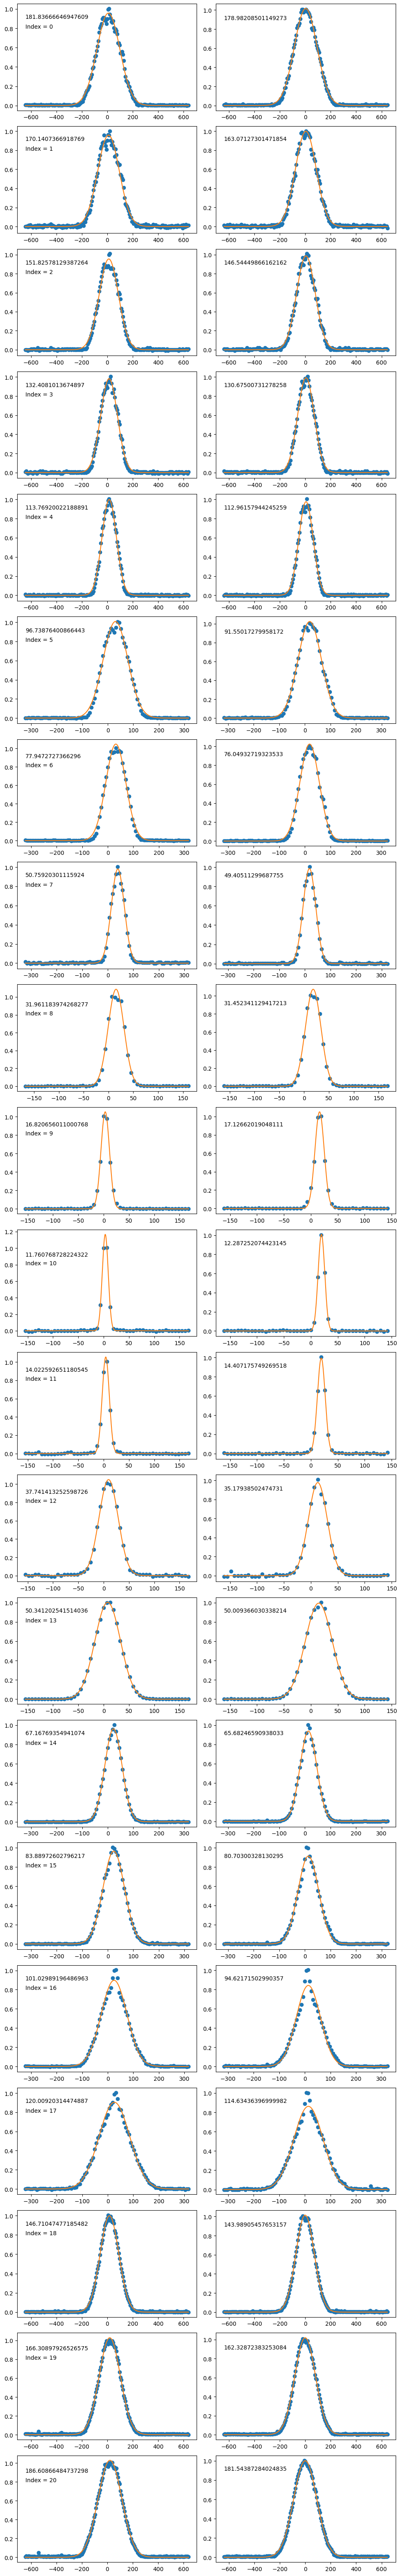

In [26]:
# Prepare data structure
W = np.zeros((N_MEASUREMENTS,2))    # First column for beam widths; Second column for error on beam widths
p0x = p0y = [1,0,100]    # First guess for fitting
fig, ax = plt.subplots(N_MEASUREMENTS, 2, figsize=(10,3*N_MEASUREMENTS), tight_layout=True)

# Compute results for every measurement
for i in range(N_MEASUREMENTS):
    ## Prepare data from measurement
    ### Load x and y data separately from pandas data set
    xdata = DATA[i].iloc[:,0:2]
    ydata = DATA[i].iloc[:,2:4]
    # Drop possible NaNs caused by an assymmetric measurement window
    ydata = ydata.dropna()
    xdata = xdata.dropna()
    
    # Load the different axes for convenient usage
    xpos = xdata.iloc[:,0]
    Ix = xdata.iloc[:,1]/100
    ypos = ydata.iloc[:,0]
    Iy = ydata.iloc[:,1]/100
    
    ## Actual fit
    x_fit, _ = curve_fit(gaussian, xpos, Ix, p0x, bounds=[[0,-np.inf,0],[np.inf,np.inf,np.inf]])
    y_fit, _ = curve_fit(gaussian, ypos, Iy, p0y, bounds=[[0,-np.inf,0],[np.inf,np.inf,np.inf]])
    p0x = x_fit    # Adjust first guess to the current fitting results; only works if data is chronological
    p0y = y_fit
    sigma_x = np.sqrt(x_fit[2]/(2*np.sqrt(2*np.pi)*x_fit[0]))
    sigma_y = np.sqrt(y_fit[2]/(2*np.sqrt(2*np.pi)*y_fit[0]))

    
    # Calculate Beam width (e^-2) as average x-width and y-width 
    wx = 2* abs(x_fit[2])    # e^-2 definition beam width
    wy = 2* abs(y_fit[2])
    diff = abs(wx - wy)
    
    # Check if Gaussian fit has failed
    ## If Gaussian fit has failed only consider wx or wy
    if x_fit[0]<0.1:
        W[i,0] = wy
        W[i,1] = 2*sigma_y
        p0y[2] = p0x[2] = y_fit[2]
    elif y_fit[0]<0.1:
        W[i,0] = wx
        W[i,1] = 2*sigma_x
        p0x[2] = p0y[2] = x_fit[2]
    ## If Gaussian fit has not failed, map ellipse to circle with equal area           
    else:
        W[i,0] = np.sqrt(wx*wy)    # Width 
        W[i,1] = np.sqrt(wy**2 / (wx*wy) * sigma_x**2 
                         + wx**2 / (wx*wy) * sigma_y**2)    # Std

    # Plot sub-figure
    x_linspace = np.linspace(xpos[0],xpos.iloc[-1], 1000)
    y_linspace = np.linspace(ypos[0],ypos.iloc[-1], 1000)
    ## Plot x axis
    ax[i, 0].plot(xpos, Ix, 'o', label='Data')
    ax[i, 0].plot(x_linspace, gaussian(x_linspace, *x_fit), label='Fit')
    ax[i, 0].text(xpos[0],0.9,str(wx))
    ax[i,0].text(xpos[0],0.8, 'Index = ' + str(i))    # Print index
    ## Plot y axis
    ax[i, 1].plot(ypos, Iy, 'o', label='Data')
    ax[i, 1].plot(y_linspace, gaussian(y_linspace, *y_fit), label='Fit')
    ax[i, 1].text(ypos[0],0.9,str(wy))

plt.show()

### Fit beam profile

- Fit the beam radius, w(z)

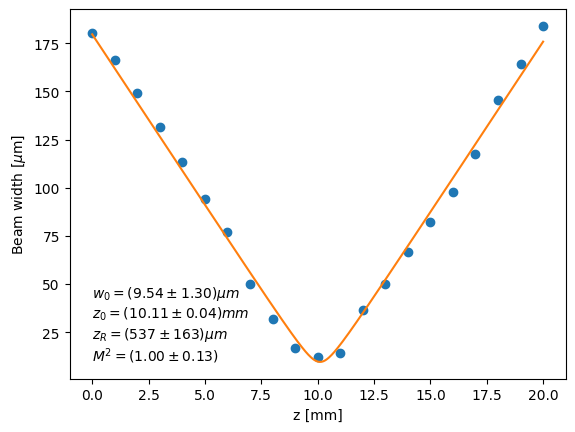

In [27]:
W_PARAM, VARW  = curve_fit(lambda x, w0, z0, M2: width(x, w0, z0, M2, WAVELENGTH), 
                     Z, W[:,0], [10,10e3,1], 
                     sigma=W[:,1], bounds=[[0,-np.inf,1],[np.inf,np.inf,np.inf]], absolute_sigma=True)
[W0, Z0, M2] =  W_PARAM
ZR = np.pi*(W0**2) / (M2*WAVELENGTH*1e-3)    # Rayleigh length

# Error propagation
SIGMA_W = np.sqrt(np.diag(VARW)[0])    # Error on beam waist
SIGMA_Z = np.sqrt(np.diag(VARW)[1])*1e-3    # Error on z-position of focal point
SIGMA_M2 = np.sqrt(np.diag(VARW)[2])    # Error on M^2
dz_dw = (2*np.pi*W0) / (M2*WAVELENGTH*1e-3)
dz_dM2 = (np.pi*(W0**2)) / (WAVELENGTH*1e-3*(M2**2))
SIGMA_ZR = np.sqrt((dz_dw**2)*(SIGMA_W**2) + (dz_dM2**2)*(SIGMA_M2**2))    # Error on Rayleigh length

## Plot
### Prepare plot
Z_PLOT = np.linspace(0,Z[-1], 500)    # linspace for plotting
textstr = '\n'.join((
    r'$w_{0}=(%.2f \pm %.2f)\mu m$' % (W0, SIGMA_W,),
    r'$z_{0}=(%.2f \pm %.2f)mm$' % (Z0*1e-3, SIGMA_Z,),
    r'$z_{R}=(%.0f \pm %.0f)\mu m$' % (ZR, SIGMA_ZR,),
    r'$M^{2}=(%.2f \pm %.2f)$' % (M2, SIGMA_M2,)))
fig2 = plt.figure()
### Plot
plt.plot(Z, W[:,0],'o', label='Data')
plt.plot(Z_PLOT, width(Z_PLOT, *W_PARAM, WAVELENGTH), label='Fit')
plt.text(0,10,textstr)
### Labels
plt.ylabel('Beam width [$\mu$m]')
plt.xlabel('z [mm]')

plt.show()

## Export Results

- Export results in text-file
- Export figures

In [28]:
# Create export directory
timeCode = datetime.now()
EXPORT_DIRECTORY = DIRECTORY + "/OUTPUT_BEAM_PROFILE_"  + timeCode.strftime("%Y%m%d-%H%M")
os.mkdir(EXPORT_DIRECTORY)
os.chdir(EXPORT_DIRECTORY)

# Save figures
fig.savefig("OUTPUT_WIDTHS.png", bbox_inches='tight')
fig2.savefig('OUTPUT_BEAM_PROFILE.png', bbox_inches='tight')

# Prepare export structure
EXPORT_DATA = np.ndarray((5,4), dtype=object)
EXPORT_TITLE = 'RESULTS_BEAM_PROFILE.txt'

# Write labels
EXPORT_DATA[0,0] = 'Parameter'
EXPORT_DATA[0,1] = 'Value'
EXPORT_DATA[0,2] = 'Sigma'
EXPORT_DATA[0,3] = 'Unit'

EXPORT_DATA[1,0] = 'w0'
EXPORT_DATA[2,0] = 'z0'
EXPORT_DATA[3,0] = 'M2'
EXPORT_DATA[4,0] = 'zR'

# Write data
EXPORT_DATA[1,1] = W0    # Unit um
EXPORT_DATA[2,1] = Z0 *1e-3    # Unit mm
EXPORT_DATA[3,1] = M2
EXPORT_DATA[4,1] = ZR    # Unit um

EXPORT_DATA[1,2] = SIGMA_W
EXPORT_DATA[2,2] = SIGMA_Z
EXPORT_DATA[3,2] = SIGMA_M2
EXPORT_DATA[4,2] = SIGMA_ZR

# Write units
EXPORT_DATA[1,3] = 'um'
EXPORT_DATA[2,3] = 'mm'
EXPORT_DATA[3,3] = 'NA'
EXPORT_DATA[4,3] = 'um'

np.savetxt(EXPORT_TITLE, EXPORT_DATA, fmt="%s")

# Open output folder
os.startfile(EXPORT_DIRECTORY)